# Processing

scmdata has some support for processing `ScmRun` instances to calculate statistics of interest. Here we provide examples of how to use them.

At present, we can calculate:

- crossing times (e.g. 1.5C crossing times)
- exceedance probabilities
- peak
- peak year
- categorisation in line with SR1.5
- a set of summary variables

## Load some data

For this demonstration, we are going to use MAGICC output from [RCMIP Phase 2] as available at [https://zenodo.org/record/4624566/files/data-processed-submission-database-hadcrut5-target-MAGICCv7.5.1.tar.gz?download=1](). Here we have just extracted the air temperature output for the SSPs from 1995 to 2100.

In [1]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
import pandas as pd
import scmdata.processing
from scmdata import ScmRun, run_append

import matplotlib.pyplot as plt
import seaborn as sns

/Users/znicholls/Documents/AGCEC/MCastle/scmdata/src/scmdata/processing.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
# NBVAL_IGNORE_OUTPUT
magicc_output = ScmRun("magicc-rcmip-phase-2-gsat-output.csv")
magicc_output

<scmdata.ScmRun (timeseries: 4800, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region scenario unit  \
	0     MAGICCv7.5.1                0  unspecified  World   ssp585    K   
	1     MAGICCv7.5.1                1  unspecified  World   ssp585    K   
	2     MAGICCv7.5.1                2  unspecified  World   ssp585    K   
	3     MAGICCv7.5.1                3  unspecified  World   ssp585    K   
	4     MAGICCv7.5.1                4  unspecified  World   ssp585    K   
	...            ...              ...          ...    ...      ...  ...   
	4795  MAGICCv7.5.1              595  unspecified  World   ssp119    K   
	4796  MAGICCv7.5.1              596  unspecified  World   ssp119    K   
	4797  MAGICCv7.5.1              597  unspecified  World   ssp119    K   
	4798  MAGICCv7.5.1              598  unspecified  World   ssp119    K   
	4799  MAGICCv7.5.1              599  unspecified  World   ssp119  

## Crossing times

The first thing we do is show how to calculate the crossing times of a given threshold.

In [3]:
# NBVAL_IGNORE_OUTPUT
crossing_time_15 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=1.5,
)
crossing_time_15

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change    2025.0
               1                unspecified  World   ssp585    K     Surface Air Temperature Change    2029.0
               2                unspecified  World   ssp585    K     Surface Air Temperature Change    2024.0
               3                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
               4                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
                                                                                                        ...  
               595              unspecified  World   ssp119    K     Surface Air Temperature Change    2023.0
               596              unspecified  World   ssp119    K     Surface Air Temperature Change       NaN
               597  

The output is a `pd.Series`, which is useful for many other pieces of work.

For example, we could make a plot with e.g. seaborn.

<AxesSubplot:xlabel='1.5C crossing time', ylabel='Count'>

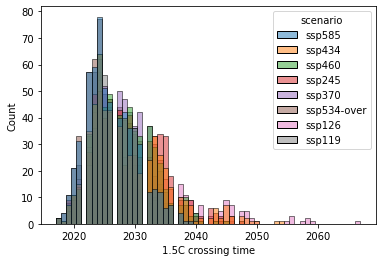

In [4]:
label = "1.5C crossing time"
pdf = crossing_time_15.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

<AxesSubplot:xlabel='2.0C crossing time', ylabel='Count'>

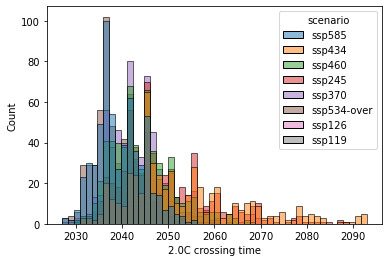

In [5]:
label = "2.0C crossing time"
crossing_time_20 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=2.0,
)

pdf = crossing_time_20.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

### Datetime output

If desired, data could be interpolated first before calculating the crossing times. In such cases, returning the output as datetime rather than year might be helpful.

In [6]:
scmdata.processing.calculate_crossing_times(
    magicc_output.resample("MS"), threshold=2.0, return_year=False,
)

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change   2042-02-01
               1                unspecified  World   ssp585    K     Surface Air Temperature Change   2041-10-01
               2                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-11-01
               3                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-09-01
               4                unspecified  World   ssp585    K     Surface Air Temperature Change   2036-01-01
                                                                                                         ...    
               595              unspecified  World   ssp119    K     Surface Air Temperature Change          NaT
               596              unspecified  World   ssp119    K     Surface Air Temperature Change          

## Exceedance probabilities

Next we show how to calculate exceedance probabilities.

In [7]:
exceedance_probability_2C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    process_over_cols=["ensemble_member", "variable"],
    threshold=2.0,
)
exceedance_probability_2C

climate_model  model        region  scenario     unit         
MAGICCv7.5.1   unspecified  World   ssp119       dimensionless    0.091667
                                    ssp126       dimensionless    0.350000
                                    ssp245       dimensionless    0.995000
                                    ssp370       dimensionless    1.000000
                                    ssp434       dimensionless    0.868333
                                    ssp460       dimensionless    1.000000
                                    ssp534-over  dimensionless    0.983333
                                    ssp585       dimensionless    1.000000
Name: 2.0 exceedance probability, dtype: float64


We can make a plot to compare exceedance probabilities over multiple scenarios.

,climate_model,model,region,scenario,unit,variable,Exceedance probability
0,MAGICCv7.5.1,unspecified,World,ssp119,dimensionless,2.0 exceedance probability,0.091667
1,MAGICCv7.5.1,unspecified,World,ssp126,dimensionless,2.0 exceedance probability,0.350000
2,MAGICCv7.5.1,unspecified,World,ssp245,dimensionless,2.0 exceedance probability,0.995000
3,MAGICCv7.5.1,unspecified,World,ssp370,dimensionless,2.0 exceedance probability,1.000000
4,MAGICCv7.5.1,unspecified,World,ssp434,dimensionless,2.0 exceedance probability,0.868333
5,MAGICCv7.5.1,unspecified,World,ssp460,dimensionless,2.0 exceedance probability,1.000000
6,MAGICCv7.5.1,unspecified,World,ssp534-over,dimensionless,2.0 exceedance probability,0.983333
7,MAGICCv7.5.1,unspecified,World,ssp585,dimensionless,2.0 exceedance probability,1.000000
8,MAGICCv7.5.1,unspecified,World,ssp119,dimensionless,1.5 exceedance probability,0.743333
9,MAGICCv7.5.1,unspecified,World,ssp126,dimensionless,1.5 exceedance probability,0.940000


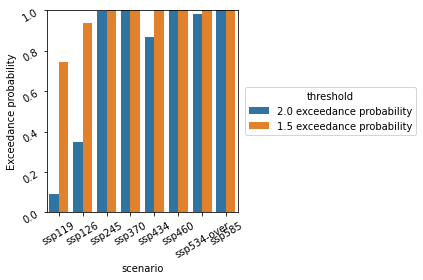

In [8]:
exceedance_probability_15C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    process_over_cols=["ensemble_member", "variable"],
    threshold=1.5,
)

pdf = (
    pd.DataFrame([exceedance_probability_2C, exceedance_probability_15C,])
    .T.melt(ignore_index=False, value_name="Exceedance probability")
    .reset_index()
)
display(pdf)

ax = sns.barplot(
    data=pdf, x="scenario", y="Exceedance probability", hue="variable"
)
ax.tick_params(labelrotation=30)
ax.set_ylim([0, 1])
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), title="threshold")
plt.tight_layout()

## Exceedance probabilities over time

It is also possible to calculate exceedance probabilities over time.

<AxesSubplot:xlabel='time', ylabel='dimensionless'>

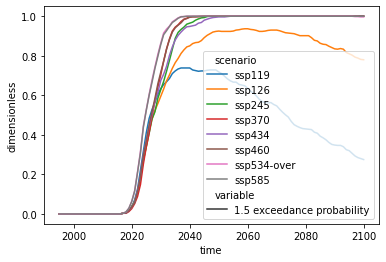

In [9]:
res = scmdata.processing.calculate_exceedance_probabilities_over_time(
    magicc_output, process_over_cols="ensemble_member", threshold=1.5,
)
res = scmdata.ScmRun(res)
res.lineplot(style="variable")

Note that taking the maximum exceedance probability over all time will be less than or equal to the exceedance probability calculated with `calculate_exceedance_probabilities` because the order of operations matters: calculating whether each ensemble member exceeds the threshold or not then seeing how many ensemble members out of the total exceed the threshold is not the same as seeing how many ensemble members exceed the threshold at each timestep and then taking the maximum over all timesteps. In general, taking the maximum value from `calculate_exceedance_probabilities_over_time` will be less than or equal to the results of `calculate_exceedance_probabilities`, as demonstrated below.

In [10]:
comparison = (
    pd.DataFrame(
        {
            "calculate_exceedance_probabilities": exceedance_probability_15C,
            "max of calculate_exceedance_probabilities_over_time": (
                res.timeseries(
                    meta=exceedance_probability_15C.index.names
                ).max(axis=1)
            ),
        }
    )
    * 100
)
comparison.round(1)

calculate_exceedance_probabilities  \
climate_model model       region scenario    unit                                                
MAGICCv7.5.1  unspecified World  ssp119      dimensionless                                74.3   
                                 ssp126      dimensionless                                94.0   
                                 ssp245      dimensionless                               100.0   
                                 ssp370      dimensionless                               100.0   
                                 ssp434      dimensionless                               100.0   
                                 ssp460      dimensionless                               100.0   
                                 ssp534-over dimensionless                               100.0   
                                 ssp585      dimensionless                               100.0   

                                                            max of calculate_exceedance_probabilities_over_time  
climate_model model       region scenario    unit                                                                
MAGICCv7.5.1  unspecified World  ssp119      dimensionless                                               73.8    
                                 ssp126      dimensionless                                               93.7    
                                 ssp245      dimensionless                                              100.0    
                                 ssp370      dimensionless                                              100.0    
                                 ssp434      dimensionless                                              100.0    
                                 ssp460      dimensionless                                              100.0    
                                 ssp534-over dimensionless                                              100.0    
                                 ssp585      dimensionless                                              100.0

## Peak

We can calculate the peaks in each timeseries.

In [11]:
peak_warming = scmdata.processing.calculate_peak(magicc_output)
peak_warming

climate_model  ensemble_member  model        region  scenario  unit  variable                           
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Peak Surface Air Temperature Change    4.448044
               1                unspecified  World   ssp585    K     Peak Surface Air Temperature Change    5.372057
               2                unspecified  World   ssp585    K     Peak Surface Air Temperature Change    5.942238
               3                unspecified  World   ssp585    K     Peak Surface Air Temperature Change    5.220904
               4                unspecified  World   ssp585    K     Peak Surface Air Temperature Change    5.637467
                                                                                                              ...   
               595              unspecified  World   ssp119    K     Peak Surface Air Temperature Change    1.809161
               596              unspecified  World   ssp119    K     Peak Su

From this we can then calculate median peak warming by scenario (or other quantiles).

In [12]:
peak_warming.groupby(["model", "scenario"]).median()

model        scenario   
unspecified  ssp119         1.653154
             ssp126         1.878890
             ssp245         2.838238
             ssp370         4.372581
             ssp434         2.371833
             ssp460         3.485626
             ssp534-over    2.613975
             ssp585         5.278692
Name: 0, dtype: float64

Or make a plot.

<AxesSubplot:xlabel='Peak warming', ylabel='Count'>

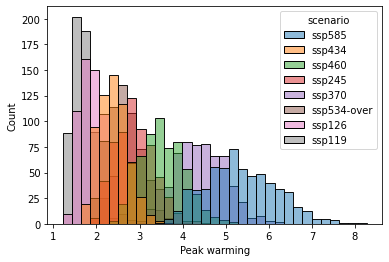

In [13]:
label = "Peak warming"
pdf = peak_warming.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

Similarly to exceedance probabilties, the order of operations matters: calculating the median of the peaks is different to calculating the median then taking the peak of this median timeseries. In general, the max of the median timeseries is less than or equal to the median of the peak in each timeseries.

In [14]:
comparison = pd.DataFrame(
    {
        "median of peak warming": peak_warming.groupby(
            ["model", "scenario"]
        ).median(),
        "max of median timeseries": (
            magicc_output.process_over(
                list(set(magicc_output.meta.columns) - {"model", "scenario"}),
                "median",
            ).max(axis=1)
        ),
    }
)
comparison.round(3)

median of peak warming  max of median timeseries
model       scenario                                                     
unspecified ssp119                        1.653                     1.645
            ssp126                        1.879                     1.874
            ssp245                        2.838                     2.838
            ssp370                        4.373                     4.373
            ssp434                        2.372                     2.368
            ssp460                        3.486                     3.486
            ssp534-over                   2.614                     2.613
            ssp585                        5.279                     5.279

## Peak time

We can calculate the peak time in each timeseries.

In [15]:
peak_warming_year = scmdata.processing.calculate_peak_time(magicc_output)
peak_warming_year

climate_model  ensemble_member  model        region  scenario  unit  variable                                   
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Year of peak Surface Air Temperature Change    2100
               1                unspecified  World   ssp585    K     Year of peak Surface Air Temperature Change    2100
               2                unspecified  World   ssp585    K     Year of peak Surface Air Temperature Change    2100
               3                unspecified  World   ssp585    K     Year of peak Surface Air Temperature Change    2100
               4                unspecified  World   ssp585    K     Year of peak Surface Air Temperature Change    2100
                                                                                                                    ... 
               595              unspecified  World   ssp119    K     Year of peak Surface Air Temperature Change    2048
               596              unspecif

From this we can then calculate median peak warming time by scenario (or other quantiles).

In [16]:
peak_warming_year.groupby(["model", "scenario"]).median()

model        scenario   
unspecified  ssp119         2048.0
             ssp126         2069.0
             ssp245         2100.0
             ssp370         2100.0
             ssp434         2094.0
             ssp460         2100.0
             ssp534-over    2060.0
             ssp585         2100.0
Name: 0, dtype: float64

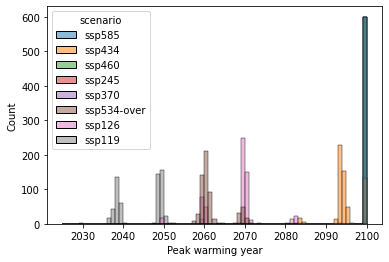

In [17]:
label = "Peak warming year"
pdf = peak_warming_year.reset_index().rename({0: label}, axis="columns")
ax = sns.histplot(
    data=pdf, x=label, hue="scenario", bins=np.arange(2025, 2100 + 1)
)

## SR1.5 categorisation
 
It is also possible to categorise the scenarios using the same categorisation as in SR1.5. To do this we have to first calculate the appropriate quantiles.

In [18]:
magicc_output_categorisation_quantiles = scmdata.ScmRun(
    magicc_output.quantiles_over(
        "ensemble_member", quantiles=[0.33, 0.5, 0.66]
    )
)
magicc_output_categorisation_quantiles

/Users/znicholls/Documents/AGCEC/MCastle/scmdata/src/scmdata/run.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


<scmdata.ScmRun (timeseries: 24, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	   climate_model        model  quantile region     scenario unit  \
	0   MAGICCv7.5.1  unspecified      0.33  World       ssp119    K   
	1   MAGICCv7.5.1  unspecified      0.33  World       ssp126    K   
	2   MAGICCv7.5.1  unspecified      0.33  World       ssp245    K   
	3   MAGICCv7.5.1  unspecified      0.33  World       ssp370    K   
	4   MAGICCv7.5.1  unspecified      0.33  World       ssp434    K   
	5   MAGICCv7.5.1  unspecified      0.33  World       ssp460    K   
	6   MAGICCv7.5.1  unspecified      0.33  World  ssp534-over    K   
	7   MAGICCv7.5.1  unspecified      0.33  World       ssp585    K   
	8   MAGICCv7.5.1  unspecified      0.50  World       ssp119    K   
	9   MAGICCv7.5.1  unspecified      0.50  World       ssp126    K   
	10  MAGICCv7.5.1  unspecified      0.50  World       ssp245    K   
	11  MAGICCv7.5.1  unspecified      0.50  World       s

In [19]:
scmdata.processing.categorisation_sr15(
    magicc_output_categorisation_quantiles, ["climate_model", "scenario"]
)

climate_model  scenario   
MAGICCv7.5.1   ssp119         1.5C high overshoot
               ssp126                   Higher 2C
               ssp245                    Above 2C
               ssp370                    Above 2C
               ssp434                    Above 2C
               ssp460                    Above 2C
               ssp534-over               Above 2C
               ssp585                    Above 2C
Name: category, dtype: object

## Set of summary variables

It is also possible to calculate a set of summary variables using the convenience function `calculate_summary_stats`. The documentation is given below.

In [20]:
print(scmdata.processing.calculate_summary_stats.__doc__)


    Calculate common summary statistics

    Parameters
    ----------
    scmrun : :class:`scmdata.ScmRun`
        Data of which to calculate the stats

    index : list[str]
        Columns to use in the index of the output (unit is added if not
        included)

    exceedance_probabilities_threshold : list[float]
        Thresholds to use for exceedance probabilities

    exceedance_probabilities_variable : str
        Variable to use for exceedance probability calculations

    exceedance_probabilities_naming_base : str
        String to use as the base for naming the exceedance probabilities. Each
        exceedance probability output column will have a name given by
        ``exceedance_probabilities_naming_base.format(threshold)`` where
        threshold is the exceedance probability threshold to use. If not
        supplied, the default output of
        :func:`scmdata.processing.calculate_exceedance_probabilities` will be
        used.

    peak_quantiles : list[float]
    

It can be used to calculate summary statistics as shown below.

In [21]:
summary_stats = scmdata.processing.calculate_summary_stats(
    magicc_output,
    ["climate_model", "model", "scenario", "region"],
    exceedance_probabilities_thresholds=np.arange(1, 2.51, 0.1),
    exceedance_probabilities_variable="Surface Air Temperature Change",
    exceedance_probabilities_naming_base="Exceedance Probability|{:.2f}K",
    peak_quantiles=[0.05, 0.5, 0.95],
    peak_variable="Surface Air Temperature Change",
    peak_naming_base="Peak Surface Air Temperature Change|{}th quantile",
    peak_time_naming_base="Year of peak Surface Air Temperature Change|{}th quantile",
    peak_return_year=True,
    progress=True,
)
summary_stats

/Users/znicholls/Documents/AGCEC/MCastle/scmdata/src/scmdata/run.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


  0%|          | 0/23 [00:00<?, ?it/s]

climate_model  model        scenario  region  unit           statistic                                                  
MAGICCv7.5.1   unspecified  ssp119    World                  SR1.5 category                                                 1.5C high overshoot
                                              K              Peak Surface Air Temperature Change|0.05th quantile                       1.345672
                                                             Peak Surface Air Temperature Change|0.5th quantile                        1.653154
                                                             Peak Surface Air Temperature Change|0.95th quantile                       2.071348
                                                             Year of peak Surface Air Temperature Change|0.05th quantile                 2037.0
                                                                                                                                   ...         
               

We can then use pandas to create summary tables of interest.

In [22]:
summary_stats.unstack(["climate_model", "statistic", "unit"])

climate_model                          MAGICCv7.5.1  \
statistic                            SR1.5 category   
unit                                                  
model       scenario    region                        
unspecified ssp119      World   1.5C high overshoot   
            ssp126      World             Higher 2C   
            ssp245      World              Above 2C   
            ssp370      World              Above 2C   
            ssp434      World              Above 2C   
            ssp460      World              Above 2C   
            ssp534-over World              Above 2C   
            ssp585      World              Above 2C   

climate_model                                                                       \
statistic                      Peak Surface Air Temperature Change|0.05th quantile   
unit                                                                             K   
model       scenario    region                                                       
unspecified ssp119      World                                            1.345672    
            ssp126      World                                            1.478604    
            ssp245      World                                            2.218657    
            ssp370      World                                            3.476406    
            ssp434      World                                            1.898714    
            ssp460      World                                            2.753816    
            ssp534-over World                                            2.100912    
            ssp585      World                                            4.094323    

climate_model                                                                      \
statistic                      Peak Surface Air Temperature Change|0.5th quantile   
unit                                                                            K   
model       scenario    region                                                      
unspecified ssp119      World                                            1.653154   
            ssp126      World                                             1.87889   
            ssp245      World                                            2.838238   
            ssp370      World                                            4.372581   
            ssp434      World                                            2.371833   
            ssp460      World                                            3.485626   
            ssp534-over World                                            2.613975   
            ssp585      World                                            5.278692   

climate_model                                                                       \
statistic                      Peak Surface Air Temperature Change|0.95th quantile   
unit                                                                             K   
model       scenario    region                                                       
unspecified ssp119      World                                            2.071348    
            ssp126      World                                            2.425129    
            ssp245      World                                            3.642782    
            ssp370      World                                             5.35643    
            ssp434      World                                            2.958278    
            ssp460      World                                            4.373157    
            ssp534-over World                                            3.299928    
            ssp585      World                                             6.75008    

climate_model                                                                               \
statistic                      Year of peak Surface Air Temperature Change|0.05th quantile   
unit                                                            

In [23]:
# NBVAL_IGNORE_OUTPUT
index = ["climate_model", "scenario"]
pivot_merge_unit = summary_stats.to_frame().reset_index()
pivot_merge_unit["statistic"] = pivot_merge_unit[
    "statistic"
] + pivot_merge_unit["unit"].apply(lambda x: "({})".format(x) if x else "")
pivot_merge_unit = pivot_merge_unit.drop("unit", axis="columns")
pivot_merge_unit = pivot_merge_unit.set_index(
    list(set(pivot_merge_unit.columns) - {"value"})
).unstack("statistic")
pivot_merge_unit

value  \
statistic                                    Exceedance Probability|1.00K(dimensionless)   
scenario    model       region climate_model                                               
ssp119      unspecified World  MAGICCv7.5.1                                          1.0   
ssp126      unspecified World  MAGICCv7.5.1                                          1.0   
ssp245      unspecified World  MAGICCv7.5.1                                          1.0   
ssp370      unspecified World  MAGICCv7.5.1                                          1.0   
ssp434      unspecified World  MAGICCv7.5.1                                          1.0   
ssp460      unspecified World  MAGICCv7.5.1                                          1.0   
ssp534-over unspecified World  MAGICCv7.5.1                                          1.0   
ssp585      unspecified World  MAGICCv7.5.1                                          1.0   

                                                                                          \
statistic                                    Exceedance Probability|1.10K(dimensionless)   
scenario    model       region climate_model                                               
ssp119      unspecified World  MAGICCv7.5.1                                          1.0   
ssp126      unspecified World  MAGICCv7.5.1                                          1.0   
ssp245      unspecified World  MAGICCv7.5.1                                          1.0   
ssp370      unspecified World  MAGICCv7.5.1                                          1.0   
ssp434      unspecified World  MAGICCv7.5.1                                          1.0   
ssp460      unspecified World  MAGICCv7.5.1                                          1.0   
ssp534-over unspecified World  MAGICCv7.5.1                                          1.0   
ssp585      unspecified World  MAGICCv7.5.1                                          1.0   

                                                                                          \
statistic                                    Exceedance Probability|1.20K(dimensionless)   
scenario    model       region climate_model                                               
ssp119      unspecified World  MAGICCv7.5.1                                          1.0   
ssp126      unspecified World  MAGICCv7.5.1                                          1.0   
ssp245      unspecified World  MAGICCv7.5.1                                          1.0   
ssp370      unspecified World  MAGICCv7.5.1                                          1.0   
ssp434      unspecified World  MAGICCv7.5.1                                          1.0   
ssp460      unspecified World  MAGICCv7.5.1                                          1.0   
ssp534-over unspecified World  MAGICCv7.5.1                                          1.0   
ssp585      unspecified World  MAGICCv7.5.1                                          1.0   

                                                                                          \
statistic                                    Exceedance Probability|1.30K(dimensionless)   
scenario    model       region climate_model                                               
ssp119      unspecified World  MAGICCv7.5.1                                     0.976667   
ssp126      unspecified World  MAGICCv7.5.1                                          1.0   
ssp245      unspecified World  MAGICCv7.5.1                                          1.0   
ssp370      unspecified World  MAGICCv7.5.1                                          1.0   
ssp434      unspecified World  MAGICCv7.5.1                                          1.0   
ssp460      unspecified World  MAGICCv7.5.1                                          1.0   
ssp534-over unspecified World  MAGICCv7.5.1                                          1.0   
ssp585      unspecified World  MAGICCv7.5.1                                          1.0   

                               